<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/15_applying_HMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 15: Applying Hamiltonian Monte Carlo to Bayesian Logistic Regression


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: October 22nd, 11:59pm EST

**Names of Group Members**: 

- Alex Spiride: aspiride@college.harvard.edu
- Matthieu Meeus: matthieu_meeus@g.harvard.edu
- Maggie Wang: maggiewang@college.harvard.edu
- Will Seaton: wseaton@g.harvard.edu
- Nari Johnson njohnson@college.harvard.edu


## Learning Goals:

1. Verify your implementation of HMC
2. Use your HMC sampler to sample from the posterior of Bayesian Logistic Regression models
3. Evaluate the predictive uncertainties of Bayesian Logistic Regression models for toy datasets


### Load necessary libraries

In [ ]:
!pip install pymc3==3.8
!pip install arviz

### Import basic libraries
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from pymc3 import model_to_graphviz, Model
import pymc3 as pm
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from sklearn.datasets import make_classification
%matplotlib inline

In [ ]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5
        
    i = 0
    
    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)
        
        i += 1
        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
      return sigmoid(x.dot(self.slopes) + self.intercept)

## Problem 1: Unit Testing HMC for Bayesian Logistic Regression

In this problem, we test your implementation of HMC from In-Class Exercise 10.20 on Bayesian logistic regression models.

**Exercise 1:** Check that your implementation of HMC from In-Class Exercise 10.20 is correct by sampling from the posterior of the following Bayesian logistic regression model:
\begin{align}
w &\sim \mathcal{N}(0, 1)\\
Y^{(n)} &\sim Ber(\text{sigm}(wX^{(n)} + 10))
\end{align}
  where $w$, $Y^{(n)}$, $X^{(n)}$ are a real scalar valued random variables, and where the data consists of a single observation $(Y=1, X=-20)$. You can use the same kinetic energy function as in In-Class Exercise 10.20.

First you'll need to verify that we can perform HMC on the posterior without knowing the normalizing constant. By Bayes rule, the posterior $p(w|\text{Data})= \frac{ p(w)\prod_{n=1}^N p(Y^{(n)} |X^{(n)} , w)}{\mathcal{Z}}$, where $\mathcal{Z}$ is a normalizing constant defined by a complicated integral. Argue that we do not need to evaluate $\mathcal{Z}$ for HMC sampling from the posterior. In particular, examine the Metropolis-Hasting acceptance mechanism in HMC and argue that the normalizing constant is not needed; furthermore, examine the gradient update steps in the leap-frog integrator and argue that we do not need the normalizing constant in the gradient update.

You might want to check samples from your implementation against samples from `pymc3`. The true posterior $p(w | Y=1, X=-20)$ should look like the following (i.e. the true posterior is left-skewed):

<img src="https://i.ibb.co/R2PP4yC/logistic-posterior.png" style='height:100px;'>

**Answer:**

Let's first consider the normalizing constant ${\mathcal{Z}}$. When it comes to the HMC, we will be minimizing $U(q) = - \log(\pi(q))$. as we're taking the log, the constant denominator ${\mathcal{Z}}$ can be left out of consideration when minimizing. 

During the MH step, we know from previous homeworks and lectures that the normalizing contant disappears because the expression of the acceptance probability cis the following:

$\alpha = \min\left(1, \exp\left\{H(q^{(current)}, p^{(current)}) - H(q^{(\text{step } T)}, p^{(\text{step } T)})\right\} \right)$

$H(q)$ again contains the log of ${\mathcal{Z}}$ in the denominator. Hence, subtracting two evaluations of $H(q)$ will make the normalizing constant cancel out. 

In [ ]:
# start with code form last lecture

from scipy.stats import norm

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def pi(q):
  return 1 / np.sqrt(2*np.pi) * np.exp(-q*q/2) * ((sigmoid(q * X + 10))**Y) * ((1 - sigmoid(q * X + 10))**(1-Y))

def U(q):
  return - np.log(pi(q))

def K(p):
  p = np.array([p])
  return 1/2 * np.transpose(p) @ np.linalg.inv(M) @ p + 1/2 * np.linalg.norm(M) + D/2 * np.log(2*np.pi)

def H(q, p):
  return U(q) + K(p)

q_curr = np.random.random()

In [ ]:
m = 5
D = 1
M = np.eye(D) * m
L = 20
eps = 1e-2

X = -20.
Y = 1.

thinning = 2
burn_in = 200
n_iter = 1000 * thinning + burn_in

qs = np.zeros(n_iter)

for i in range(n_iter):
  qs[i] = q_curr
  p_curr = np.random.normal(scale=m)
  p_step = p_curr
  q_step = q_curr
  for i in range(L):
    p_step -= eps/2 * grad(U)(q_step)
    q_step += eps/m * p_step
    p_step -= eps/2 * grad(U)(q_step)
  p_step = - p_step

  # simultion error MH accept mechanism
  alpha = np.min([1, np.exp(H(q_curr, p_curr) - H(q_step, p_step))])
  if np.random.uniform() <= alpha:
    q_curr = q_step
    p_curr = p_step

q_samples = qs[burn_in::thinning]

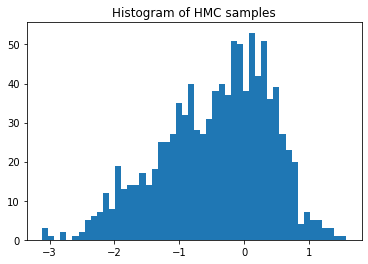

Text(0.5, 1.0, 'Traceplot of HMC samples')

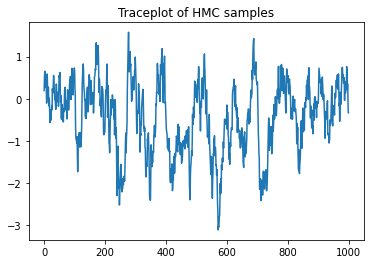

In [ ]:
plt.hist(q_samples, bins = 50)
plt.title('Histogram of HMC samples')
plt.show()

plt.plot(range(len(q_samples)), q_samples)
plt.title('Traceplot of HMC samples')

This looks fairly similar to the given histogram. 

**Exercise 2:** Check that your implementation of HMC from In-Class Exercise 10.20 is correct by sampling from the posterior of the following Bayesian logistic regression model:

\begin{align}
w_i &\sim \mathcal{N}(0, 10)\\
Y^{(n)} &\sim Ber(\text{sigm}(w_2 X_1^{(n)} + w_1 X_2^{(n)} + w_0))
\end{align}

where $w_i$, $Y^{(n)}$, $X_i^{(n)}$ are real scalar valued random variables, and where the data consists of multiple observations $\{(x_1^{(n)}, x_2^{(n)}, y^{(n)}) \}$ (see toy data below). You should use a different kinetic energy function that in Exercise 1 (in particular, think about what is the dimensionality of your momentum vector?).

You might want to check samples from your implementation against samples from `pymc3`.

In [ ]:
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

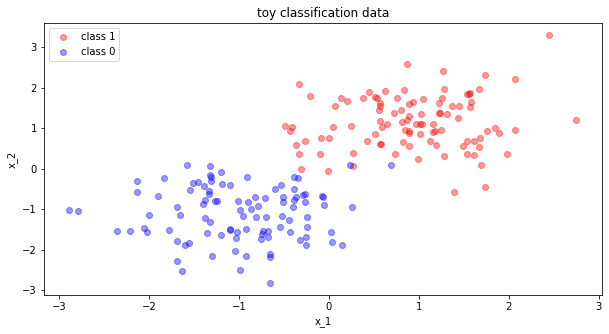

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.4, c='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.4, c='blue', label='class 0')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

In [ ]:
# let's do our code first

### TO DO: dimensions don't work!!

from scipy.stats import norm

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def pi(q):
  print(-np.dot(q,q))
  print(sigmoid(X@q)**Y)
  return 1 / np.sqrt(2*np.pi) * np.exp(-np.dot(q,q)/2) * np.prod(((sigmoid(X@q))**Y) * ((1 - sigmoid(X@q))**(1-Y)))

def U(q):
  return - np.log(pi(q))

def K(p):
  print(p)
  print(M)
  return 1/2 * np.transpose(p) @ np.linalg.inv(M) @ p + 1/2 * np.linalg.norm(M) + D/2 * np.log(2*np.pi)

def H(q, p):
  return U(q) + K(p)

q_curr = np.random.random(3).reshape(1,3)

In [ ]:
### TO DO: dimensions don't work!!

m = 5
D = 3
M = np.eye(D) * m
L = 20
eps = 1e-2

X = np.hstack((x, np.ones((len(x),1)))) 
Y = y

thinning = 2
burn_in = 200
n_iter = 1000 * thinning + burn_in

qs = []

for i in range(n_iter):
  qs.append(q_curr)
  p_curr = np.random.multivariate_normal(mean = np.zeros(3), cov=M, size = 1)
  p_step = p_curr
  q_step = q_curr
  for i in range(L):
    p_step -= eps/2 * grad(U)(q_step)
    q_step += eps/m * p_step
    p_step -= eps/2 * grad(U)(q_step)
  p_step = - p_step

  # simultion error MH accept mechanism
  alpha = np.min([1, np.exp(H(q_curr, p_curr) - H(q_step, p_step))])
  if np.random.uniform() <= alpha:
    q_curr = q_step
    p_curr = p_step

q_samples = qs[burn_in::thinning]

ValueError: ignored

In [ ]:
hmc_model = pm.Model()

with Model() as hmc_model:
  # Prior on weights
  w = pm.Normal('w', mu=0, sigma=10, shape=3)

  # Function
  p = pm.Deterministic('p', pm.math.sigmoid(w[2]*x[:,0] + w[1]*x[:,1] + w[0]) )

  # Likelihood
  y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

  # Sample from posterior
  trace = pm.sample(2000, tune=500)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:01<00:00, 1424.47it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


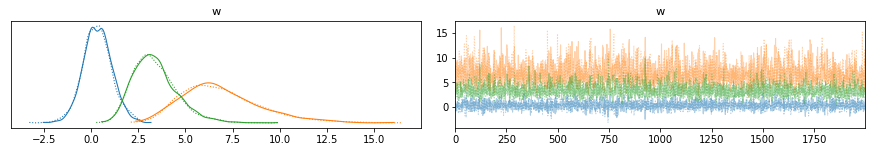

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
pm.traceplot(trace, var_names=['w'])
plt.show()

## Problem 2: Out of Distribution Uncertainty from Bayesian Logistic Regression Models

In this problem, we discuss whether or not the uncertainties from our Bayesian logistic regresson model is useful.

**Exercise 3:** Visualize the decision boundaries corresponding to the samples from the posterior (In-Class Exercise 10.13). How does uncertainty over the decision boundary relate to uncertainties in the classification of the data? 

Is the uncertainty over the decision boundary desirable -- that is, does it help us determine where the model is unreliable and must be overriden by a human expert (think about your description of desirable model uncertainty in HW#2)? 

***Hint:*** given the input (-100, -100), would the predictive uncertainty for this point be high or low? Should it be high or low?


**Exercise 4:** Just as we can cast Bayesian Non-linear Regression as a non-linear transformation of the data followed by Bayesian Linear Regression, we can perform Bayesian Logistic Regression with non-linear decision boundaries by first applying a non-linear feature map to the data and then fitting a Bayesian Logistic Regression model on the features.

Perform Bayesian Logistic Regression using your choice of feature map on the toy dataset. Visualize the decision boundaries corresponding to the samples in the posterior. Is the uncertainty over the decision boundary desirable -- that is, does it help us determine where the model is unreliable and must be overriden by a human expert?